In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
import cv2
import pandas as pd

## Laden der Bilder und Label
Die Bilder werden als Graustufenbilder in dem Feature-Vektor gespeichert. Dieser hat die Form `(Anzahl Bilder, Pixel_x, Pixel_y, Farbkanäle(1 für Graustufe, 3 für RGB)`.

Die Daten werden dann in Trainings-, Validierungs- und Testdatensätze aufgeteilt.

In [75]:
images_list = glob(r"./data/256_res/*.png")
image_names = [os.path.basename(file) for file in glob('./data/*.png')]
features = np.ndarray((len(images_list), 256, 256))
for count, image in enumerate(images_list):
    im = cv2.imread(image)
    gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    features[count, :] = gray_image

features = features[:,:,:,np.newaxis]
df_labels = pd.read_csv("./Labeling_App/Labels.csv")
df_labels = pd.get_dummies(df_labels, columns=["label"])
labels = np.array([df_labels[df_labels["file"] == image].iloc[:, 1:] for image in image_names])
labels = labels.reshape((labels.shape[0], 15))
[X_train, X_test, y_train, y_test] = train_test_split(features, labels, test_size=0.2, random_state=42)
[X_train, X_val, y_train, y_val] = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [109]:
y_train.shape

(322, 15)

<BarContainer object of 15 artists>

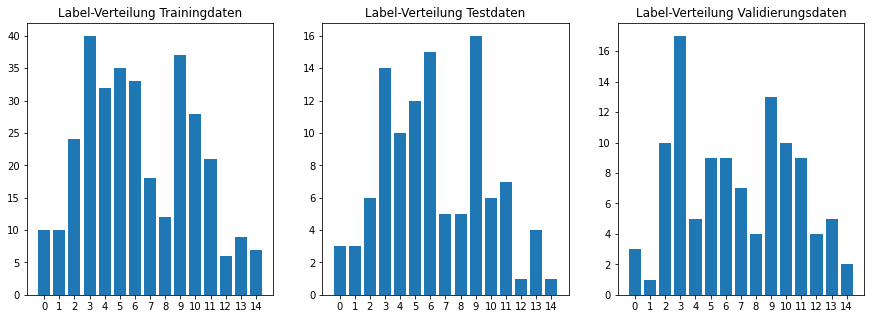

In [131]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
unique_values_train, value_count_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
unique_values_test, value_count_test = np.unique(np.argmax(y_test, axis=1), return_counts=True)
unique_values_val, value_count_val = np.unique(np.argmax(y_val, axis=1), return_counts=True)

axs[0].set_xticks(np.unique(np.argmax(y_train, axis=1)))
axs[1].set_xticks(np.unique(np.argmax(y_test, axis=1)))
axs[2].set_xticks(np.unique(np.argmax(y_val, axis=1)))

axs[0].set_title("Label-Verteilung Trainingdaten")
axs[1].set_title("Label-Verteilung Testdaten")
axs[2].set_title("Label-Verteilung Validierungsdaten")

axs[0].bar(unique_values_train, value_count_train)
axs[1].bar(unique_values_test, value_count_test)
axs[2].bar(unique_values_val, value_count_val)

## Erstellung von Schichten für Preprocessing
`resize_and_rescale` ist eine Schicht mit der die Bilder auf 256x256 skaliert werden und die Pixel-Werte auf den Wertebereich von (-1, 1) skaliert werden

`data_augmentation` sorgt dafür, dass die Bilder noch über die horizontale und vertikale Achse gespiegelt werden um mehr Daten zu generieren.

In [87]:
resize_and_rescale = Sequential([
  Resizing(256, 256),
  Rescaling(1./127.5, offset=-1) #scale image values to range (-1, 1)
])

data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical")
])

## Erstellung des CNNs

In [102]:
model = Sequential()
#add model layers
model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Conv2D(16, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

## Training des CNNs

In [103]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size = 5)

Epoch 1/10
65/65 [==============================] - 9s 130ms/step - loss: 7.7532 - accuracy: 0.1087 - val_loss: 2.6714 - val_accuracy: 0.0741
Epoch 2/10
65/65 [==============================] - 8s 126ms/step - loss: 2.5291 - accuracy: 0.1491 - val_loss: 2.6082 - val_accuracy: 0.1574
Epoch 3/10
65/65 [==============================] - 8s 126ms/step - loss: 2.2146 - accuracy: 0.3447 - val_loss: 2.5587 - val_accuracy: 0.1204
Epoch 4/10
65/65 [==============================] - 8s 125ms/step - loss: 1.6370 - accuracy: 0.5683 - val_loss: 2.5123 - val_accuracy: 0.1389
Epoch 5/10
65/65 [==============================] - 8s 127ms/step - loss: 1.0263 - accuracy: 0.7019 - val_loss: 2.6017 - val_accuracy: 0.2037
Epoch 6/10
65/65 [==============================] - 8s 129ms/step - loss: 0.7954 - accuracy: 0.7919 - val_loss: 2.6507 - val_accuracy: 0.1759
Epoch 7/10
65/65 [==============================] - 8s 127ms/step - loss: 0.7575 - accuracy: 0.7981 - val_loss: 2.5397 - val_accuracy: 0.1944
Epoch 

In [100]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 81ms/step - loss: 3.5339 - accuracy: 0.2315


[3.5339035987854004, 0.23148147761821747]

## Plotten des Fehlers auf den Trainings- und Validierungsdaten

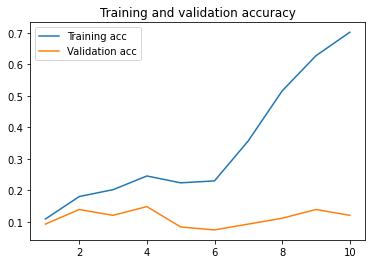

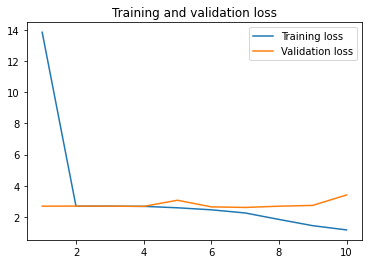

In [95]:
loss = history.history["loss"]
acc = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
